## Imports

In [69]:
import numpy as np
from sklearn import datasets
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

## Activation functions

In [2]:
def relu(Z):
    """
    Computes ReLU (Rectified Lenear Unit) activation on Z.
        Parameters:
            Z (<numpy.ndarray>)
        Returns:
            A (<numpy.ndarray>): Z passed to the relu
            cache (<numpy.ndarray>): input (for backward propagation)
    """
    A = np.maximum(0, Z)
    cache = Z
    
    return (A, cache)


def sigmoid(Z):
    """
    Computes sigmoid activation on Z.
        Parameters:
            Z (<numpy.ndarray>)
        Returns:
            A (<numpy.ndarray>): Z passed to the relu
            cache (<numpy.ndarray>): input (for backward propagation)
    """
    A = 1 / (1 + np.exp(-Z))
    cache = Z
    
    return (A, cache)

def tanh(Z):
    """
    Computes tanh activation on Z.
        Parameters:
            Z (<numpy.ndarray>)
        Returns:
            A (<numpy.ndarray>): Z passed to tanh
            cache (<numpy.ndarray>): input (for backward propagation)
    """
    A = np.tanh(Z)
    cache = Z
    
    return (A, cache)


def dummy(Z):
    """
    Dummy activation function that returns the same input
        Parameters:
            Z (<numpy.ndarray>)
        Returns:
            A (<numpy.ndarray>): Z same as it is
            cache (<numpy.ndarray>): input (for backward propagation)
    """
    A = Z
    cache = Z
    
    return (A, cache)

## Weights Initialization

### add diff inits
He, Xavier, random, zeros?

https://datascience-enthusiast.com/DL/Improving-DeepNeural-Networks-Initialization.html

In [3]:
def init_params(layers):
    """
    Initializes the weights for the (deep) neural network layers using Xavier's Initialization.
        Parameters:
            layers (tuple): tuple of layers' number of nodes and activation layers(including input layer) tuples
                ((10, ''), (5, 'relu'), (1, 'sigmoid'))
        Returns:
            params (dict): dictionary containing weights and bias per layer
                "Wn": <numpy.ndarray> weights for layer n
                "bn": <numpy.ndarray> bias for layer n
    """
    activation_func = {'relu': relu,
                                'sigmoid': sigmoid,
                                'tanh': tanh,
                                'dummy': dummy}
    params = {}
    
    layer_dims, activations = zip(*layers)
    
    nlayers = len(layer_dims)
    
    for l in range(1, nlayers):
        
        params[f"W{l}"] = np.random.rand(layer_dims[l], layer_dims[l-1]) \
        * np.sqrt(1.0/(layer_dims[l]+layer_dims[l-1]))
        
#         params[f"W{l}"] = np.random.rand(layer_dims[l], layer_dims[l-1]) * 0.01
        
#         params[f"W{l}"] = np.random.randn(layer_dims[l], layer_dims[l-1]) \
#         * np.sqrt(2/(layer_dims[l]+layer_dims[l-1]))

#         params[f"W{l}"] = np.random.randn(layer_dims[l], layer_dims[l-1]) / np.sqrt(layer_dims[l-1]) #*0.01
    
        params[f"b{l}"] = np.zeros((layer_dims[l], 1))
        
        params[f"A{l}"] = activation_func[activations[l]]
    
    return params

## Forward Propagation

In [4]:
def forward_propagate_layer(A_prev, W, b, activate_func):
    """
    Applies forward propagation (linear & activation).
    Parameters:
            A_prev (<numpy.ndarray>): this layer's input (last layer's output)
            params (dict): dictionary containing weights and bias per layer
                "Wn": <numpy.ndarray> weights for layer n
                "bn": <numpy.ndarray> bias for layer n
                "An": (<function>): activation function
        Returns:
            A (<numpy.ndarray>): layer output (post-activation)
            cache (tuple): forward propagation caches for backward
                (linear_cache, (activation_cache, activation_name))
            
    """
#     print(f"A_prev: ({A_prev.shape})")
#     print(f"W: ({W.shape})")
#     print(f"b: ({b.shape})")
    Z = W @ A_prev + b
    linear_cache = (A_prev, W, b)
    
    A, activation_cache = activate_func(Z)
    cache = (linear_cache, (activation_cache, activate_func.__name__))
    
    return (A, cache)

In [5]:
def forward_propagate(X, params):
    """
    Forward propagates X through all model layers.
    Parameters:
            X (list): this layer's input (last layer's output)
            params (dict): dictionary containing weights and bias per layer
                "Wn": <numpy.ndarray> weights for layer n
                "bn": <numpy.ndarray> bias for layer n
                "An": (<function>): activation function
        Returns:
            A (<numpy.ndarray>): model output
            cache (list): forward propagation caches for backward
                [(linear_cache, activation_cache), ...]
            
    """
    caches = []
    A = X
    nlayers = len(params) // 3
    
    for l in range(1, nlayers+1):
        A, cache = forward_propagate_layer(A, 
                                           params[f"W{l}"], 
                                           params[f"b{l}"],
                                           params[f"A{l}"])
        caches.append(cache)
    
    return (A, caches)

## Cost Computation

In [6]:
def compute_cost(Yh, Y):
    """
    Computes cost using the cross-entropy / log-loss function
    Parameters:
            Yh (<numpy.ndarray>): predicted output (y_hat)
            Y (<numpy.ndarray>): true output (y)
        Returns:
            cost (float): cost value
    """
#     print(f"Yh: {Yh.shape}")
#     print(f"Y : {Y.shape}")
    m = float(Y.shape[1])
    
#     cost = ((Y @ np.log(Yh.T)) + ((1 - Y) @ np.log((1-Yh).T))) / -m
    cost = (1./m) * (-np.dot(Y,np.log(Yh).T) - np.dot(1-Y, np.log(1-Yh).T))
    cost = np.squeeze(cost)
    
    return cost

## Backward Propagation

In [7]:
def backward_propagate_layer(dA, cache):
    """
    Applies backward propagation (linear & activation).
    Parameters:
            dA (<numpy.ndarray>): current layer's post-activation gradient 
            cache (tuple): forward propagation caches for backward
                (linear_cache, (activation_cache, activation_name))
        Returns:
            dA_prev (<numpy.ndarray>): Gradient with respect to previous layer's input (A_prev)
            dW (<numpy.ndarray>): Gradient with respect to current layer's wieghts (W)
            db (<numpy.ndarray>): Gradient with respect to previous layer's bias (b)
            
    """
    def relu_backward(dA, cache):
        """
        ReLU backward propagation implementation.
        Parameters:
            dA (<numpy.ndarray>): post-activation gradient 
            Y (<numpy.ndarray>): activation input (Z)
        Returns:
            dZ (<numpy.ndarray>): Gradient with respect to activation input (Z)
        """
        dZ = np.copy(dA)
        dZ[cache <= 0] = 0
        
        return dZ
    
    def sigmoid_backward(dA, cache):
        """
        sigmoid backward propagation implementation.
        Parameters:
            dA (<numpy.ndarray>): post-activation gradient
            Y (<numpy.ndarray>): activation input (Z)
        Returns:
            dZ (<numpy.ndarray>): Gradient with respect to activation input (Z)
        """
        s, _ = sigmoid(cache)
        dZ = dA * s * (1 - s)
        
        return dZ
    
    def tanh_backward(dA, cache):
        """
        tanh backward propagation implementation.
        Parameters:
            dA (<numpy.ndarray>): post-activation gradient
            Y (<numpy.ndarray>): activation input (Z)
        Returns:
            dZ (<numpy.ndarray>): Gradient with respect to activation input (Z)
        """
        t, _ = tanh(cache)
        dZ = dA * (1 - np.power(t, 2))
        
        return dZ
    
    def dummy_backward(dA, cache):
        """
        sigmoid backward propagation implementation.
        Parameters:
            dA (<numpy.ndarray>): post-activation gradient
            Y (<numpy.ndarray>): activation input (Z)
        Returns:
            dZ (<numpy.ndarray>): Gradient with respect to activation input (Z)
        """
        dA = dZ
        
        return dZ
    
    activation_backward_func = {'relu': relu_backward,
                                'sigmoid': sigmoid_backward,
                                'tanh': tanh_backward,
                                'dummy': dummy_backward}

    linear_cache, (activation_cache, activation_name) = cache
    
    # Activation backward propagation
    dZ = activation_backward_func[activation_name](dA, activation_cache)
    
    A_prev, W, b = linear_cache
    m = float(A_prev.shape[1])
    # Linear backward propagation
    dA_prev = W.T @ dZ
    dW = (dZ @ A_prev.T) / m
    db = np.sum(dZ, 1, keepdims=True) / m
    
    return (dA_prev, dW, db)

In [8]:
def backward_propagate(Yh, Y, caches):
    """
    Backward propagates Error through all model layers.
    Parameters:
            Yh (<numpy.ndarray>): predicted output (y_hat)
            Y (<numpy.ndarray>): true output (y)
            cache (list): forward propagation caches
                [(linear_cache, activation_cache), ...]
        Returns:
            grads (dict): dictionary containing parameters' gradients
                "dAn": <numpy.ndarray> weights for layer n (*deprecated)
                "dWn": <numpy.ndarray> weights for layer n
                "dbn": <numpy.ndarray> bias for layer n      
    """
    grads = {}
    nlayers = len(caches)
    
#     grads[f"dA{nlayers}"] = (Yh - Y) / ((1 - Yh) * Yh)
    grads[f"dA{nlayers}"] = - (np.divide(Y, Yh) - np.divide(1 - Y, 1 - Yh))
    
    for l in range(nlayers, 0, -1):
        current_cache = caches[l-1]
        dA_prev, dW, db = backward_propagate_layer(grads[f"dA{l}"], 
                                                   current_cache)
        grads[f"dA{l-1}"] = dA_prev
        grads[f"dW{l}"] = dW
        grads[f"db{l}"] = db
    
    return grads

## Update Parameters (with Gradient Descent)

In [9]:
def update_params(params, grads, lr):
    """
    Apply Gradient Descent to update parameters using 
        computed gradients and learning rate.
    Parameters:
        params (dict): dictionary containing weights and bias per layer
                    "Wn": <numpy.ndarray> weights for layer n
                    "bn": <numpy.ndarray> bias for layer n
                    "An": (<function>): activation function
        grads (dict): dictionary containing parameters' gradients
                    "dAn": <numpy.ndarray> weights for layer n (*deprecated)
                    "dWn": <numpy.ndarray> weights for layer n
                    "dbn": <numpy.ndarray> bias for layer n 
        lr (float): learning rate
    Returns:
        params (dict): *updated dictionary containing weights and bias per layer
                    "Wn": <numpy.ndarray> weights for layer n
                    "bn": <numpy.ndarray> bias for layer n
                    "An": (<function>): activation function
    """
    
    nlayers = len(params) // 3
#     print(nlayers)
    for l in range(1, nlayers+1):
        params[f"W{l}"] -= (lr * grads[f"dW{l}"])
        params[f"b{l}"] -= (lr * grads[f"db{l}"])
    
    return params

## Putting it all together

In [110]:
type(True)

bool

In [103]:
def my_dnn(X, Y, layers, lr=0.005, niters=100, verbose=False, savefigs=False, cmap = plt.cm.Spectral):
    """
    Create a model using "layers" and train the model on X & y.
    Parameters:
        X (<numpy.ndarray>): input samples
        Y (<numpy.ndarray>): samples expected output
        layers (tuple): tuple of layers' number of nodes and activation layers(including input layer) tuples
                ((10, ''), (5, 'relu'), (1, 'sigmoid'))
        lr (float): learning rate
        niters (int): number of iterations
        verbose (bool): displays cost while training
        savefigs (bool): visualizes model output while training (use for 2D inputs)
        cmap (<maplotlib.pyplot.cm>): colormap for visualization (use when savefigs=True)
        
        
    Returns:
        params (dict): dictionary containing trained weights and bias per layer
                    "Wn": <numpy.ndarray> weights for layer n
                    "bn": <numpy.ndarray> bias for layer n
                    "An": (<function>): activation function
    """
    if Y.ndim == 1:
        Y = np.reshape(Y, (1, -1))
    ndigits = len(str(niters))
    ndisplays = (niters//10)
    nsaves = (niters//20)
    costs = []
    
    params = init_params(layers)
    print(score(X, y, params))
    for i in range(niters+1):
        
        A, caches = forward_propagate(X, params)
        
        cost = compute_cost(A, Y)
        
        grads = backward_propagate(A, Y, caches)
        
        params = update_params(params, grads, lr)
        
        if verbose and not (i % ndisplays):
            print(f"Cost at i={i:0{ndigits}} = {cost:.4f}")
        
        if savefigs and not (i % nsaves):
            plot_decision_boundary(lambda x: predict(x.T, params), X, Y, figname=f"plt{i:0{ndigits}}", cmap=cmap)
        
        costs.append(cost)
    
    print(score(X, y, params))
    
    return params

In [24]:
def score(X, y, params):
    """
    Calculates score of samples using passed parameters.
    Parameters:
        X (<numpy.ndarray>): samples
        Y (<numpy.ndarray>): samples expected output
        params (dict): dictionary containing trained weights and bias per layer
                    "Wn": <numpy.ndarray> weights for layer n
                    "bn": <numpy.ndarray> bias for layer n
                    "An": (<function>): activation function
    Returns:
        score (float): model's score/accuracy (0 -> 1)
    """
    score = np.mean(predict(X, params)==y)
    return score

In [35]:
def predict(X, params):
    """
    Apply Gradient Descent to update parameters using 
        computed gradients and learning rate.
    Parameters:
        X (<numpy.ndarray>): input samples
        params (dict): dictionary containing weights and bias per layer
                    "Wn": <numpy.ndarray> weights for layer n
                    "bn": <numpy.ndarray> bias for layer n
                    "An": (<function>): activation function
    Returns:
        Yh (<numpy.ndarray>): predicted output (y_hat)
    """
    A2, cache = forward_propagate(X, params)
    Yh = (A2 > 0.5)
    
    return Yh

In [81]:
def plot_decision_boundary(model, X, y, figname=None, cmap = plt.cm.Spectral):
    """
    Plots model output.
    """
    # Set min and max values and give it some padding
    x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
    y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole grid
    Z = model(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=cmap)
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.scatter(X[0, :], X[1, :], c=y, cmap=cmap)
    if figname:
        plt.title(f"Decision Boundary on epoch: {int(figname[3:])}")    
        plt.savefig(f"plots/{figname}")

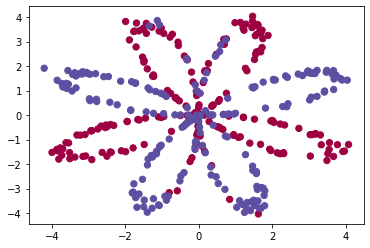

In [72]:
def load_planar_dataset():
    np.random.seed(1)
    m = 400 # number of examples
    N = int(m/2) # number of points per class
    D = 2 # dimensionality
    X = np.zeros((m,D)) # data matrix where each row is a single example
    Y = np.zeros((m,1), dtype='uint8') # labels vector (0 for red, 1 for blue)
    a = 4 # maximum ray of the flower

    for j in range(2):
        ix = range(N*j,N*(j+1))
        t = np.linspace(j*3.12,(j+1)*3.12,N) + np.random.randn(N)*0.2 # theta
        r = a*np.sin(4*t) + np.random.randn(N)*0.2 # radius
        X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
        Y[ix] = j
        
    X = X.T
    Y = Y.T

    return X, Y

X, y = load_planar_dataset()

# Visualize the data:
plt.scatter(X[0, :], X[1, :], c=y, s=40, cmap=plt.cm.Spectral);

0.34
Cost at i=0000 = 0.7279
Cost at i=0500 = 0.6495
Cost at i=1000 = 0.3386
Cost at i=1500 = 0.3083
Cost at i=2000 = 0.2966
Cost at i=2500 = 0.2882
Cost at i=3000 = 0.2813
Cost at i=3500 = 0.2746
Cost at i=4000 = 0.2678
Cost at i=4500 = 0.2605
Cost at i=5000 = 0.2560
0.89


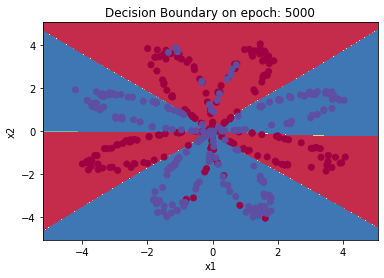

In [65]:
params = my_dnn(X, y, 
                ((2, ''), *((5, 'tanh'),) * 3, (1, 'sigmoid')), 
                lr = 0.1,
                niters=5000,
                verbose=True,
                savefigs=True)

plot_decision_boundary(lambda x: predict(x.T, params), X, y)

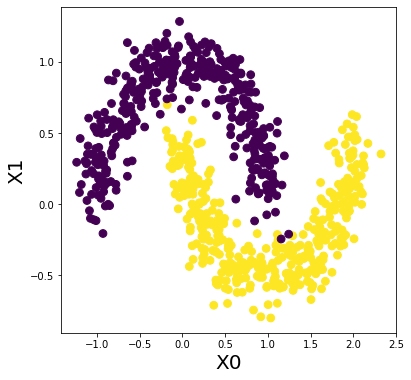

In [75]:
X, y = datasets.make_moons(800, noise=0.12, random_state=10)
X = X.T

fig, ax = plt.subplots(figsize=(6, 6))
plt.xlabel("X0", fontsize=20)
plt.ylabel("X1", fontsize=20)
plt.scatter(X[0,:], X[1,:], s=60, c=y)

0.51375
Cost at i=0000 = 0.7064
Cost at i=0500 = 0.2723
Cost at i=1000 = 0.2678
Cost at i=1500 = 0.1797
Cost at i=2000 = 0.0216
Cost at i=2500 = 0.0165
Cost at i=3000 = 0.0149
Cost at i=3500 = 0.0140
Cost at i=4000 = 0.0136
Cost at i=4500 = 0.0133
Cost at i=5000 = 0.0131
0.99375


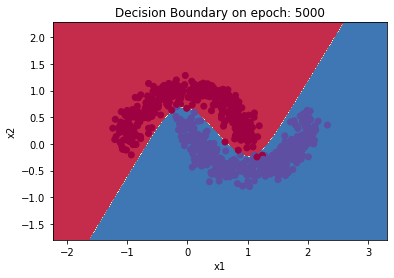

In [68]:
params = my_dnn(X, y, 
                ((2, ''), *((5, 'tanh'),) * 3, (1, 'sigmoid')), 
                lr = 0.1,
                niters=5000,
                verbose=True,
                savefigs=True)

plot_decision_boundary(lambda x: predict(x.T, params), X, y)

In [ ]:
plot_color_gradients('Diverging',
                     ['PiYG', 'PRGn', 'BrBG', 'PuOr', 'RdGy', 'RdBu', 'RdYlBu',
                      'RdYlGn', 'Spectral', 'coolwarm', 'bwr', 'seismic'])

In [ ]:
gaussian_quantiles = sklearn.datasets.make_gaussian_quantiles(mean=None, cov=0.5, n_samples=N, n_features=2, n_classes=2, shuffle=True, random_state=None)

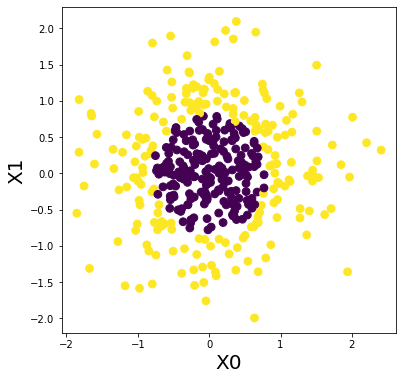

In [101]:
X, y = datasets.make_gaussian_quantiles(mean=None, cov=0.5, n_samples=400, n_features=2, n_classes=2, shuffle=True, random_state=None)
X = X.T

#
# Create the plot
#
fig, ax = plt.subplots(figsize=(6, 6))
plt.xlabel("X0", fontsize=20)
plt.ylabel("X1", fontsize=20)
plt.scatter(X[0,:], X[1,:], s=60, c=y)

0.535
Cost at i=0000 = 0.6891
Cost at i=0500 = 0.6237
Cost at i=1000 = 0.5741
Cost at i=1500 = 0.5584
Cost at i=2000 = 0.4659
Cost at i=2500 = 0.1316
Cost at i=3000 = 0.0502
Cost at i=3500 = 0.0311
Cost at i=4000 = 0.0227
Cost at i=4500 = 0.0179
Cost at i=5000 = 0.0148
1.0


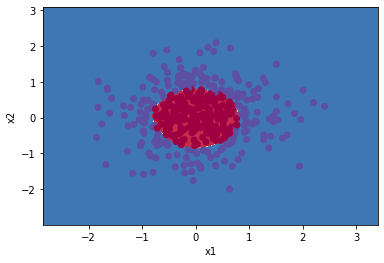

In [106]:
params = my_dnn(X, y, 
                ((2, ''), *((5, 'tanh'),) * 3, (1, 'sigmoid')), 
                lr = 0.1,
                niters=5000,
                verbose=True,
                savefigs=True, cmap)

plot_decision_boundary(lambda x: predict(x.T, params), X, y)